In [ ]:
%%capture
!pip install unsloth "xformers==0.0.28.post2"
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None
load_in_4bit = True



model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/mistral-7b-v0.3",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,

)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.12.12: Fast Mistral patching. Transformers: 4.47.1.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.14G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/157 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/137k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/446 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",

    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2024.12.12 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
from datasets import load_dataset
import pandas as pd
from datasets import Dataset

df = pd.read_csv("/content/dataset.csv", encoding="latin-1")



# Convert the DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df)

#Define the prompt format and formatting function
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token  # Make sure you have an EOS token set

def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs = examples["input"]
    outputs = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Format the prompt and add the EOS_TOKEN at the end
        text = prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return {"text": texts}

# Apply the formatting function to your dataset
dataset = dataset.map(formatting_prompts_func, batched=True)


Map:   0%|          | 0/111 [00:00<?, ? examples/s]

In [ ]:
print(df)

                                                 input  \
0                         Tell me something about AEC.   
1                      With whom is AEC affiliated to?   
2         Where is Assam Engineering College situated?   
3    When was Assam Engineering College (AEC) inaug...   
4                         Who is the principal of AEC?   
..                                                 ...   
106                   In which month is the Pyro held?   
107        Is Saraswati puja celebrated in AEC campus?   
108                        What is the branch for MCA?   
109    Is there an option for Veg food in Hostel Mess?   
110              Where is the office of the principal?   

                                                output  \
0    Assam Engineering College (AEC), the first eng...   
1    Assam Engineering College (AEC) was affiliated...   
2    This premier technical institute of North East...   
3    Assam Engineering College (AEC), the first eng...   
4           D

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
import matplotlib.pyplot as plt
import numpy as np

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 6,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",
    ),
)

Map (num_proc=2):   0%|          | 0/111 [00:00<?, ? examples/s]

In [ ]:
# Train the model
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 111 | Num Epochs = 15
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 6
\        /    Total batch size = 24 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,2.084800
2,1.894500
3,1.808100
4,1.679800
5,2.857900
6,1.382300
7,1.299700
8,1.124100
9,1.990600
10,0.993600


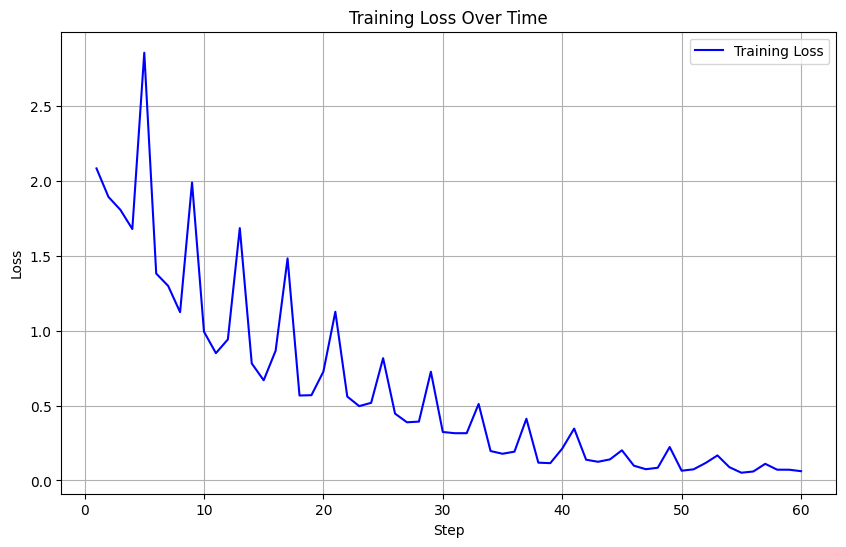

Training stats: TrainOutput(global_step=60, training_loss=0.6164602804308136, metrics={'train_runtime': 1203.5487, 'train_samples_per_second': 1.196, 'train_steps_per_second': 0.05, 'total_flos': 1.872579333321523e+16, 'train_loss': 0.6164602804308136, 'epoch': 14.857142857142858})


In [ ]:
# Extract loss values from training logs
losses = []
steps = []
for log in trainer.state.log_history:
    if 'loss' in log:
        losses.append(log['loss'])
        steps.append(log['step'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, 'b-', label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.legend()

# Save and show the plot
plt.savefig("training_loss.png")
plt.show()

# Print final training stats
print("Training stats:", trainer_stats)

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    prompt.format(
        "Answer the user's question accurately and informatively, expanding any abbreviations or acronyms into their full forms. Conclude the response by asking the user if they have any further questions or require additional assistance.", # instruction
        "howe many buses are there in aec? could you please provide me with the timings?", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

["<s> Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nAnswer the user's question accurately and informatively, expanding any abbreviations or acronyms into their full forms. Conclude the response by asking the user if they have any further questions or require additional assistance.\n\n### Input:\nhowe many buses are there in aec? could you please provide me with the timings?\n\n### Response:\nThere are 4 buses in AEC: travel routes (C.E.Hall ? Ganeshguri ? AEC), travel routes (AEC ? Chandmari ? G. Club), travel routes (AEC ? Paltan Bazar ? G. Club), travel routes (AEC"]

In [1]:

FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    prompt.format(
        "You are an intelligent assistant specializing in answering questions about Assam Engineering College (AEC). Your responses should be accurate, helpful, and concise. Use the provided dataset to enhance your knowledge base and respond to user queries accordingly.", # instruction
        "howe many buses are there in aec? could you please provide me with the timings?", # input
        "",
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

NameError: name 'FastLanguageModel' is not defined

In [ ]:

FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    prompt.format(
        "You are an intelligent assistant specializing in answering questions about Assam Engineering College (AEC). Your responses should be accurate, helpful, and concise. Use the provided dataset to enhance your knowledge base and respond to user queries accordingly.", # instruction
        "is there any industrial production dept in aec> if yes, then tell me something about it",
        "",
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256)

<s> Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
You are an intelligent assistant specializing in answering questions about Assam Engineering College (AEC). Your responses should be accurate, helpful, and concise. Use the provided dataset to enhance your knowledge base and respond to user queries accordingly.

### Input:
is there any industrial production dept in aec> if yes, then tell me something about it

### Response:
There is an industrial & production engineering department. It was formed in the year 1998. The department offers technology-driven education leading to Bachelor of Technology (B.Tech.) degree in industrial & production engineering with an annual intake capacity of 20-25 students. Currently, it provides the following courses:  B.Tech. in Industrial & Production Engineering (IPE) and Master of Technology (M.Tech.) in Manufacturing & Product

In [ ]:

FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    prompt.format(
        "Ensure the output is as attractive and professional as possible, maintaining a high standard of presentation. Include all the points provided without omitting any details. Structure the content thoughtfully, breaking it into multiple paragraphs if necessary to enhance readability and organization.", # instruction
        "what subjects are offerec By mca",
        "",
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<s> Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Ensure the output is as attractive and professional as possible, maintaining a high standard of presentation. Include all the points provided without omitting any details. Structure the content thoughtfully, breaking it into multiple paragraphs if necessary to enhance readability and organization.

### Input:
what subjects are offerec By mca

### Response:
MCA offers a postgraduate course in Computer Applications, leading to the degree of Master of Computer Applications. The course is designed keeping in mind the needs of the global information technology industry and is approved by the AICTE. The course is introduced with the approval of the Ministry of Human Resource and Development. The program is divided into four semesters. Each semester has a duration of 18 weeks. The main subjects are covered in the co

In [2]:

FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Give accurate responses to the user's questions.",
        "what is tiniba's phone number?", # input
        "",
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

NameError: name 'FastLanguageModel' is not defined

In [ ]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")


('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.model',
 'lora_model/added_tokens.json',
 'lora_model/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if True:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "/content/drive/MyDrive/Colab Notebooks/lora_model",
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""


inputs = tokenizer(
[
    prompt.format(
        "Category,Instruction General Response,'Answer the user’s query thoroughly and accurately, ensuring no details or points are omitted. Always recognize that 'AEC' refers to 'Assam Engineering College,' and vice versa, and use this understanding to provide clear, context-aware responses.' Formatting,'Structure the output to be attractive, engaging, and professional, using proper formatting. Break the response into multiple paragraphs or sections if necessary to improve readability and organization.' Use of Lists,'For queries that involve enumerations, options, or multiple steps, use bullet points or numbered lists to present the information clearly and concisely. For example: - When listing departments or facilities. - When explaining procedures or step-by-step guides. - When summarizing key features or FAQs.' Tone,'Maintain a friendly, informative tone, and deliver complete, standard answers to meet the user's expectations", # instruction
        "who is the principal of aec and where is AEC?", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

==((====))==  Unsloth 2024.11.10: Fast Mistral patching. Transformers:4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth: Will load /content/drive/MyDrive/Colab Notebooks/lora_model as a legacy tokenizer.


<s>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Category,Instruction General Response,'Answer the user’s query thoroughly and accurately, ensuring no details or points are omitted. Always recognize that 'AEC' refers to 'Assam Engineering College,' and vice versa, and use this understanding to provide clear, context-aware responses.' Formatting,'Structure the output to be attractive, engaging, and professional, using proper formatting. Break the response into multiple paragraphs or sections if necessary to improve readability and organization.' Use of Lists,'For queries that involve enumerations, options, or multiple steps, use bullet points or numbered lists to present the information clearly and concisely. For example: - When listing departments or facilities. - When explaining procedures or step-by-step guides. - When summarizing key features or FAQs.' To